In [2]:
from koinapy import Koina
import numpy as np
import pandas as pd

import sys
from pathlib import Path

# Alternative way if __file__ is not defined in Jupyter notebooks
project_root = Path.cwd().parent

sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from make_predictions.intensity_predictions import obtain_predictions_pairs

Project root added to sys.path: c:\Users\robbi\OneDrive\Documents\GitHub\spectral_similarity


In [4]:
peptides = np.array(
    [
        ["PTAQPIVQDHK", "PTAQPLVQDHK"],
        ["GQEGQDHGKEDDHDSSIGQNSDSK", "GQEGQDHGKEDDHDSSLGQNSDSK"],
    ]
)

obtain_predictions_pairs(peptides)

UniSpec::   0%|          | 0/1 [00:00<?, ?it/s]

,peptide_sequences,precursor_charges,collision_energies,instrument_types,intensities,mz,annotation
0,PTAQPIVQDHK,2,28,LUMOS,0.073021,110.071273,IHA
0,PTAQPIVQDHK,2,28,LUMOS,0.000461,156.076753,IHF
0,PTAQPIVQDHK,2,28,LUMOS,0.003003,175.118952,IKF
0,PTAQPIVQDHK,2,28,LUMOS,0.044692,101.070939,IQA
0,PTAQPIVQDHK,2,28,LUMOS,0.000320,129.065854,IQD
...,...,...,...,...,...,...,...
3,GQEGQDHGKEDDHDSSLGQNSDSK,2,28,LUMOS,0.001177,678.305309,y6
3,GQEGQDHGKEDDHDSSLGQNSDSK,2,28,LUMOS,0.025722,735.326773,y7
3,GQEGQDHGKEDDHDSSLGQNSDSK,2,28,LUMOS,0.002376,736.329773,y7+i
3,GQEGQDHGKEDDHDSSLGQNSDSK,2,28,LUMOS,0.003847,848.410837,y8


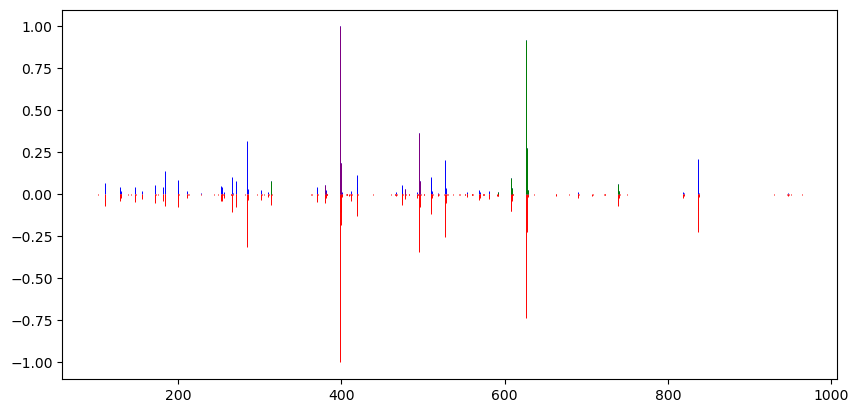

In [3]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
fig.set_figwidth(10)

predI = predictions.query(f"peptide_sequences == '{peptides[0][0]}' and peptide_sequences.str.contains('I')")
bee = predI.query(f"annotation.str.contains('b5|b4')")
why = predI.query(f"annotation.str.contains('y5|y6')")
predL = predictions.query(f"peptide_sequences == '{peptides[0][1]}' and peptide_sequences.str.contains('L')")

ax.vlines(predI['mz'], ymin=0, ymax=predI['intensities'], color='b', linewidth=0.7)
ax.vlines(predL['mz'], ymin=-predL['intensities'], ymax=0, color='r', linewidth=0.7)
ax.vlines(bee['mz'], ymin=0, ymax=bee['intensities'], color='purple', linewidth=0.7)
ax.vlines(why['mz'], ymin=0, ymax=why['intensities'], color='green', linewidth=0.7)

plt.show()

In [11]:
import metrics.metrics as M

keys = [m for m in dir(M) if ((m[:2] != "__") & (m != "binarize") & (m != "normalize"))]
keys = [
    "mse",
    "sequest_score",
    "andromeda_score",
    "pearson_correlation",
    "spearman_correlation",
    "dot_product",
    "mara_similarity",
    "modified_dot_product",
    "massbank_score",
    "gnps_score",
    "stein_scott_score",
    "wasserstein",
    "kendall_tau",
    "mutual_information",
    "bray_curtis",
    "canberra_distance",
    "mara_weighted_similarity",
    "diagnostic_weighted_similarity",
]

In [12]:
dic = {"peptideL": [], "peptideI": []}
for i in range(peptides.shape[0]):
    pepI = peptides[i, 0]
    predI = predictions.query(
        f"peptide_sequences == '{pepI}' and peptide_sequences.str.contains('I')"
    )
    bee = predI.query(f"annotation.str.contains('b5|b4')")
    why = predI.query(f"annotation.str.contains('y5|y6')")
    pepL = peptides[i, 1]
    predL = predictions.query(
        f"peptide_sequences == '{pepL}' and peptide_sequences.str.contains('L')"
    )

    dic["peptideL"].append(pepL)
    dic["peptideI"].append(pepI)

    # Find all matching annotations
    cross_ref = (
        predI["annotation"].to_numpy()[None] == predL["annotation"].to_numpy()[:, None]
    )
    match_mask = cross_ref.sum(1) == 1
    ann_inds2 = cross_ref[match_mask].argmax(1)

    # Truncated dataframes for matches
    predL_ = predL[match_mask]
    predI_ = predI.iloc[ann_inds2]

    # Run through and print out similarity scores
    for key in keys:
        if key not in dic:
            dic[key] = []
        inp = {
            "intensity1": predL_["intensities"].to_numpy(),
            "intensity2": predI_["intensities"].to_numpy(),
            "mz1": predL_["mz"].to_numpy(),
            "mz2": predI_["mz"].to_numpy(),
            "diagnostic_mz": pd.concat([bee, why])["mz"].to_numpy(),
            "mz": predL_["mz"].to_numpy(),
        }
        score = getattr(M, key)(**inp)
        dic[key].append(score)
df = pd.DataFrame(dic)

In [13]:
df

,peptideL,peptideI,mse,sequest_score,andromeda_score,pearson_correlation,spearman_correlation,dot_product,mara_similarity,modified_dot_product,massbank_score,gnps_score,stein_scott_score,wasserstein,kendall_tau,mutual_information,bray_curtis,canberra_distance,mara_weighted_similarity,diagnostic_weighted_similarity
0,PTAQPLVQDHK,PTAQPIVQDHK,0.000246,2.248419,2.248419,0.99227,0.985159,0.992848,0.891413,0.991200,0.981185,0.981185,0.992848,5.467764,0.906338,0.590307,0.057411,20.211840,0.891413,0.993260
1,GQEGQDHGKEDDHDSSLGQNSDSK,GQEGQDHGKEDDHDSSIGQNSDSK,0.000048,3.103730,3.103730,0.99846,0.981629,0.998605,0.929426,0.998742,0.997077,0.997077,0.998605,2.898527,0.893965,0.597859,0.036578,15.570403,0.929426,0.998606
